In [0]:
import os
import datetime

import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt

from skimage import color, exposure
from skimage.transform import rotate, warp, ProjectiveTransform
import cv2

In [0]:
%load_ext tensorboard
%matplotlib inline

In [3]:
cd "/content/drive/My Drive/Colab Notebooks/dw_matrix_road_sign/dw_matrix_road_sign"

/content/drive/My Drive/Colab Notebooks/dw_matrix_road_sign/dw_matrix_road_sign


In [4]:
ls

data/  day2.ipynb  day3.ipynb  day4.ipynb  LICENSE  logs/  README.md


In [0]:
signs = pd.read_csv('data/signnames.csv')
labels_dict = signs.to_dict()['b']

In [0]:
train = pd.read_pickle('data/train.p')
test = pd.read_pickle('data/test.p')

X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [7]:
y_train

array([41, 41, 41, ..., 25, 25, 25], dtype=uint8)

In [8]:
len(np.unique(y_train))

43

In [0]:
if y_train.ndim == 1:
  y_train = to_categorical(y_train)

if y_test.ndim == 1:
  y_test = to_categorical(y_test)

In [10]:
y_train.shape

(34799, 43)

In [11]:
y_test.shape

(4410, 43)

In [0]:
input_shape = X_train.shape[1:]
num_classes = y_train.shape[1]

In [0]:
def get_cnn_v1(input_shape, num_classes):
  return Sequential([
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    Flatten(),
    Dense(num_classes, activation='softmax')
  ])

In [0]:
def get_cnn_v2(input_shape, num_classes):
  return Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Flatten(),

    Dense(1024, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
  ])

In [0]:
def get_cnn_v3(input_shape, num_classes):
  return Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Flatten(),

    Dense(1024, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
  ])

In [0]:
def get_cnn_v4(input_shape, num_classes):
  return Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Flatten(),

    Dense(1024, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
  ])

In [0]:
def get_cnn_v5(input_shape, num_classes):
  return Sequential([
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Flatten(),

    Dense(1024, activation='relu'),
    Dropout(0.3),
    
    Dense(1024, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
  ])

In [0]:
def train_model(model, X_train, y_train, params_fit={}):
  model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

  log_dir = os.path.join('logs', datetime.datetime.now().strftime('%Y%m%d-%H%M%s'))
  tensordboard_callback = tf.keras.callbacks.TensorBoard(log_dir, histogram_freq=1)

  model.fit(
      X_train, 
      y_train,
      batch_size=params_fit.get('batch_size', 128),
      epochs=params_fit.get('epochs', 5),
      verbose=params_fit.get('verbose', 1),
      validation_data=params_fit.get('validation_data', (X_train, y_train)),
      callbacks=[tensordboard_callback]
      )
  
  return model

In [0]:
def predict(trained_model, X_test, y_test, scoring=accuracy_score):
  y_test_norm = np.argmax(y_test, axis=1)
  
  y_pred_prob = trained_model.predict(X_test)
  y_pred = np.argmax(y_pred_prob, axis=1)

  return scoring(y_test_norm, y_pred)

In [0]:
def train_and_predict(model, X_train, y_train, X_test, y_test):
  model_trained = train_model(model, X_train, y_train)
  return predict(model_trained, X_test, y_test)

In [0]:
def preproc_img(img):
  hsv = color.rgb2hsv(img)
  hsv[:, :, 2] = exposure.equalize_adapthist(hsv[:, :, 2])
  return color.hsv2rgb(hsv)

In [22]:
train_and_predict(get_cnn_v1(input_shape, num_classes), X_train, y_train, X_test, y_test)

Epoch 1/5
272/272 [==============================] - 7s 24ms/step - loss: 29.3065 - accuracy: 0.7101 - val_loss: 0.2065 - val_accuracy: 0.9528
Epoch 2/5
272/272 [==============================] - 6s 23ms/step - loss: 0.1954 - accuracy: 0.9569 - val_loss: 0.1558 - val_accuracy: 0.9598
Epoch 3/5
272/272 [==============================] - 6s 23ms/step - loss: 0.1233 - accuracy: 0.9706 - val_loss: 0.1086 - val_accuracy: 0.9761
Epoch 4/5
272/272 [==============================] - 6s 23ms/step - loss: 0.1063 - accuracy: 0.9769 - val_loss: 0.0763 - val_accuracy: 0.9805
Epoch 5/5
272/272 [==============================] - 6s 23ms/step - loss: 0.0806 - accuracy: 0.9816 - val_loss: 0.1291 - val_accuracy: 0.9682


0.8253968253968254

In [23]:
train_and_predict(get_cnn_v2(input_shape, num_classes), X_train, y_train, X_test, y_test)

Epoch 1/5
272/272 [==============================] - 6s 23ms/step - loss: 5.6779 - accuracy: 0.2565 - val_loss: 1.3949 - val_accuracy: 0.6420
Epoch 2/5
272/272 [==============================] - 6s 22ms/step - loss: 1.1183 - accuracy: 0.6787 - val_loss: 0.3848 - val_accuracy: 0.9135
Epoch 3/5
272/272 [==============================] - 6s 23ms/step - loss: 0.5872 - accuracy: 0.8283 - val_loss: 0.1900 - val_accuracy: 0.9580
Epoch 4/5
272/272 [==============================] - 6s 23ms/step - loss: 0.3990 - accuracy: 0.8843 - val_loss: 0.1023 - val_accuracy: 0.9745
Epoch 5/5
272/272 [==============================] - 6s 22ms/step - loss: 0.2997 - accuracy: 0.9127 - val_loss: 0.0941 - val_accuracy: 0.9829


0.916780045351474

In [24]:
train_and_predict(get_cnn_v3(input_shape, num_classes), X_train, y_train, X_test, y_test)

Epoch 1/5
272/272 [==============================] - 10s 37ms/step - loss: 2.0196 - accuracy: 0.5453 - val_loss: 0.2363 - val_accuracy: 0.9435
Epoch 2/5
272/272 [==============================] - 10s 36ms/step - loss: 0.3708 - accuracy: 0.8922 - val_loss: 0.0677 - val_accuracy: 0.9857
Epoch 3/5
272/272 [==============================] - 10s 35ms/step - loss: 0.1940 - accuracy: 0.9443 - val_loss: 0.0384 - val_accuracy: 0.9920
Epoch 4/5
272/272 [==============================] - 10s 35ms/step - loss: 0.1491 - accuracy: 0.9567 - val_loss: 0.0316 - val_accuracy: 0.9936
Epoch 5/5
272/272 [==============================] - 10s 35ms/step - loss: 0.1053 - accuracy: 0.9693 - val_loss: 0.0104 - val_accuracy: 0.9971


0.972562358276644

In [25]:
train_and_predict(get_cnn_v4(input_shape, num_classes), X_train, y_train, X_test, y_test)

Epoch 1/5
272/272 [==============================] - 12s 44ms/step - loss: 2.4931 - accuracy: 0.3316 - val_loss: 0.7384 - val_accuracy: 0.7894
Epoch 2/5
272/272 [==============================] - 11s 42ms/step - loss: 0.7455 - accuracy: 0.7703 - val_loss: 0.2367 - val_accuracy: 0.9405
Epoch 3/5
272/272 [==============================] - 11s 42ms/step - loss: 0.3626 - accuracy: 0.8901 - val_loss: 0.0809 - val_accuracy: 0.9788
Epoch 4/5
272/272 [==============================] - 11s 42ms/step - loss: 0.2391 - accuracy: 0.9268 - val_loss: 0.0437 - val_accuracy: 0.9875
Epoch 5/5
272/272 [==============================] - 12s 42ms/step - loss: 0.1795 - accuracy: 0.9455 - val_loss: 0.0312 - val_accuracy: 0.9914


0.9759637188208616

In [26]:
train_and_predict(get_cnn_v5(input_shape, num_classes), X_train, y_train, X_test, y_test)

Epoch 1/5
272/272 [==============================] - 12s 45ms/step - loss: 2.4486 - accuracy: 0.3200 - val_loss: 0.8356 - val_accuracy: 0.7379
Epoch 2/5
272/272 [==============================] - 12s 44ms/step - loss: 0.7064 - accuracy: 0.7753 - val_loss: 0.1600 - val_accuracy: 0.9507
Epoch 3/5
272/272 [==============================] - 12s 44ms/step - loss: 0.3143 - accuracy: 0.9054 - val_loss: 0.0714 - val_accuracy: 0.9815
Epoch 4/5
272/272 [==============================] - 12s 45ms/step - loss: 0.2132 - accuracy: 0.9378 - val_loss: 0.0519 - val_accuracy: 0.9858
Epoch 5/5
272/272 [==============================] - 12s 45ms/step - loss: 0.1604 - accuracy: 0.9540 - val_loss: 0.0400 - val_accuracy: 0.9891


0.9698412698412698

In [0]:
X_train_gray = color.rgb2gray(X_train).reshape(-1, 32, 32, 1)
X_test_gray = color.rgb2gray(X_test).reshape(-1, 32, 32, 1)
input_shape_gray = X_train_gray.shape[1:]

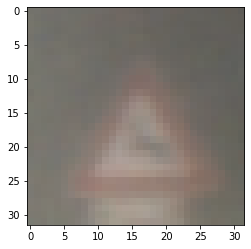

In [28]:
plt.imshow(X_train[400])

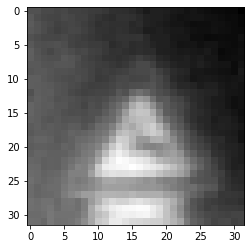

In [29]:
plt.imshow(color.rgb2gray(X_train[400]), cmap=plt.get_cmap('gray'))

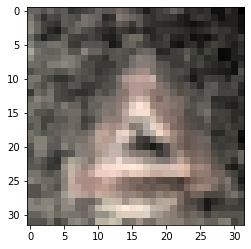

In [30]:
plt.imshow(preproc_img(X_train[400]))

In [31]:
train_and_predict(get_cnn_v5(input_shape_gray, num_classes), X_train_gray, y_train, X_test_gray, y_test)

Epoch 1/5
272/272 [==============================] - 12s 46ms/step - loss: 2.5663 - accuracy: 0.2795 - val_loss: 0.6160 - val_accuracy: 0.8058
Epoch 2/5
272/272 [==============================] - 12s 44ms/step - loss: 0.5477 - accuracy: 0.8256 - val_loss: 0.1410 - val_accuracy: 0.9571
Epoch 3/5
272/272 [==============================] - 12s 44ms/step - loss: 0.2740 - accuracy: 0.9136 - val_loss: 0.0677 - val_accuracy: 0.9827
Epoch 4/5
272/272 [==============================] - 12s 44ms/step - loss: 0.1807 - accuracy: 0.9432 - val_loss: 0.0439 - val_accuracy: 0.9866
Epoch 5/5
272/272 [==============================] - 12s 44ms/step - loss: 0.1521 - accuracy: 0.9525 - val_loss: 0.0278 - val_accuracy: 0.9919


0.9653061224489796

# Additional task

In [0]:
def rotate_image(image, max_angle =15):
    rotate_out = rotate(image, np.random.uniform(-max_angle, max_angle), mode='edge')
    return rotate_out

In [0]:
def translate_image(image, max_trans = 5, height=32, width=32):
    translate_x = max_trans*np.random.uniform() - max_trans/2
    translate_y = max_trans*np.random.uniform() - max_trans/2
    translation_mat = np.float32([[1,0,translate_x],[0,1,translate_y]])
    trans = cv2.warpAffine(image, translation_mat, (height,width))
    return trans

In [0]:
def projection_transform(image, max_warp=0.8, height=32, width=32):
    #Warp Location
    d = height * 0.3 * np.random.uniform(0,max_warp)
    
    #Warp co-ordinates
    tl_top = np.random.uniform(-d, d)     # Top left corner, top margin
    tl_left = np.random.uniform(-d, d)    # Top left corner, left margin
    bl_bottom = np.random.uniform(-d, d)  # Bottom left corner, bottom margin
    bl_left = np.random.uniform(-d, d)    # Bottom left corner, left margin
    tr_top = np.random.uniform(-d, d)     # Top right corner, top margin
    tr_right = np.random.uniform(-d, d)   # Top right corner, right margin
    br_bottom = np.random.uniform(-d, d)  # Bottom right corner, bottom margin
    br_right = np.random.uniform(-d, d)   # Bottom right corner, right margin
        
    ##Apply Projection
    transform = ProjectiveTransform()
    transform.estimate(np.array((
                (tl_left, tl_top),
                (bl_left, height - bl_bottom),
                (height - br_right, height - br_bottom),
                (height - tr_right, tr_top)
            )), np.array((
                (0, 0),
                (0, height),
                (height, height),
                (height, 0)
            )))
    output_image = warp(image, transform, output_shape=(height, width), order = 1, mode = 'edge')
    return output_image

In [0]:
def transform_image(image, max_angle=15, max_trans =5 ,max_warp=0.8):
    ## Simple pipline to take an input image and apply a serise of simple
    ## Distortions to augment the training data set
    ## (note: this function will rescale pixel values between 0-1)
    ##
    height, width, channels = image.shape
    #Rotate Image
    rotated_image = rotate_image(image, max_angle)
    #Translate Image
    translated_image = translate_image(rotated_image, max_trans, height, width)
    #Project Image
    output_image = projection_transform(translated_image, max_warp, height, width)
    return (output_image*255.0).astype(np.uint8)

In [0]:
def augment_data(X_train):
  X_aug = np.copy(X_train)
  for i in range(len(X_train)):
    X_aug[i,:,:,:] = transform_image(X_train[i]).reshape((1, 32, 32, 3))
  return X_aug

In [0]:
X_train_aug = augment_data(X_train)
X_test_aug = augment_data(X_test)

In [58]:
train_and_predict(get_cnn_v1(input_shape, num_classes), X_train_aug, y_train, X_test_aug, y_test)

Epoch 1/5
272/272 [==============================] - 6s 23ms/step - loss: 30.1925 - accuracy: 0.1941 - val_loss: 2.5193 - val_accuracy: 0.3316
Epoch 2/5
272/272 [==============================] - 6s 22ms/step - loss: 2.4056 - accuracy: 0.3566 - val_loss: 1.9493 - val_accuracy: 0.4594
Epoch 3/5
272/272 [==============================] - 6s 22ms/step - loss: 1.9172 - accuracy: 0.4578 - val_loss: 1.5212 - val_accuracy: 0.5646
Epoch 4/5
272/272 [==============================] - 6s 23ms/step - loss: 1.6297 - accuracy: 0.5301 - val_loss: 1.2980 - val_accuracy: 0.6219
Epoch 5/5
272/272 [==============================] - 6s 23ms/step - loss: 1.4253 - accuracy: 0.5824 - val_loss: 1.1789 - val_accuracy: 0.6548


0.3219954648526077

In [59]:
train_and_predict(get_cnn_v2(input_shape, num_classes), X_train_aug, y_train, X_test_aug, y_test)

Epoch 1/5
272/272 [==============================] - 6s 23ms/step - loss: 6.0636 - accuracy: 0.1149 - val_loss: 3.1190 - val_accuracy: 0.1420
Epoch 2/5
272/272 [==============================] - 6s 22ms/step - loss: 3.0173 - accuracy: 0.1657 - val_loss: 2.8426 - val_accuracy: 0.2045
Epoch 3/5
272/272 [==============================] - 6s 22ms/step - loss: 2.4752 - accuracy: 0.3020 - val_loss: 1.9394 - val_accuracy: 0.4294
Epoch 4/5
272/272 [==============================] - 6s 22ms/step - loss: 1.9736 - accuracy: 0.3987 - val_loss: 1.5145 - val_accuracy: 0.5292
Epoch 5/5
272/272 [==============================] - 6s 22ms/step - loss: 1.6226 - accuracy: 0.4921 - val_loss: 1.1919 - val_accuracy: 0.6297


0.4879818594104308

In [60]:
train_and_predict(get_cnn_v3(input_shape, num_classes), X_train_aug, y_train, X_test_aug, y_test)

Epoch 1/5
272/272 [==============================] - 10s 36ms/step - loss: 2.9106 - accuracy: 0.2646 - val_loss: 1.6250 - val_accuracy: 0.5350
Epoch 2/5
272/272 [==============================] - 10s 35ms/step - loss: 1.5298 - accuracy: 0.5418 - val_loss: 0.8675 - val_accuracy: 0.7611
Epoch 3/5
272/272 [==============================] - 10s 35ms/step - loss: 0.9645 - accuracy: 0.7050 - val_loss: 0.4159 - val_accuracy: 0.8880
Epoch 4/5
272/272 [==============================] - 10s 35ms/step - loss: 0.6570 - accuracy: 0.7991 - val_loss: 0.2748 - val_accuracy: 0.9273
Epoch 5/5
272/272 [==============================] - 10s 35ms/step - loss: 0.5003 - accuracy: 0.8463 - val_loss: 0.1999 - val_accuracy: 0.9492


0.8566893424036282

In [61]:
train_and_predict(get_cnn_v4(input_shape, num_classes), X_train_aug, y_train, X_test_aug, y_test)

Epoch 1/5
272/272 [==============================] - 12s 43ms/step - loss: 2.8973 - accuracy: 0.2156 - val_loss: 1.8080 - val_accuracy: 0.4145
Epoch 2/5
272/272 [==============================] - 11s 42ms/step - loss: 1.7123 - accuracy: 0.4521 - val_loss: 1.1213 - val_accuracy: 0.6220
Epoch 3/5
272/272 [==============================] - 11s 42ms/step - loss: 1.1372 - accuracy: 0.6330 - val_loss: 0.5345 - val_accuracy: 0.8316
Epoch 4/5
272/272 [==============================] - 11s 42ms/step - loss: 0.7521 - accuracy: 0.7641 - val_loss: 0.3502 - val_accuracy: 0.8921
Epoch 5/5
272/272 [==============================] - 11s 42ms/step - loss: 0.5608 - accuracy: 0.8238 - val_loss: 0.2453 - val_accuracy: 0.9269


0.8766439909297052

In [62]:
train_and_predict(get_cnn_v5(input_shape, num_classes), X_train_aug, y_train, X_test_aug, y_test)

Epoch 1/5
272/272 [==============================] - 12s 46ms/step - loss: 3.0967 - accuracy: 0.1796 - val_loss: 1.9210 - val_accuracy: 0.3841
Epoch 2/5
272/272 [==============================] - 12s 44ms/step - loss: 1.8917 - accuracy: 0.3937 - val_loss: 1.4061 - val_accuracy: 0.5327
Epoch 3/5
272/272 [==============================] - 12s 44ms/step - loss: 1.4003 - accuracy: 0.5429 - val_loss: 0.8189 - val_accuracy: 0.7314
Epoch 4/5
272/272 [==============================] - 12s 44ms/step - loss: 1.0103 - accuracy: 0.6686 - val_loss: 0.5461 - val_accuracy: 0.8102
Epoch 5/5
272/272 [==============================] - 12s 44ms/step - loss: 0.7579 - accuracy: 0.7563 - val_loss: 0.3611 - val_accuracy: 0.8805


0.8192743764172336

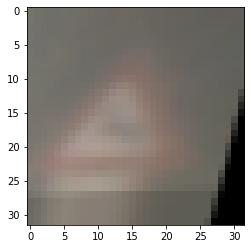

In [63]:
plt.imshow(X_train_aug[400])